### Premise

Let's take a few different pre-trained models, and test how they do across some different prompts over a set of tasks.
Specifically, we'll record how these models perform across 32 randomly sampled prompts (using a set of 200 supporting examples) for each k (number of examples in a prompt) for the ks 0, 1, 2, 4, 8, 16, 32.
We record performance over 32 examples (not very many for computational reasons) for each task.

In [1]:
import pandas as pd
import os
df = pd.concat([
    pd.read_csv(os.path.join('results_dir', 'results.csv')),
    pd.read_csv(os.path.join('results_dir2', 'results.csv')),
    pd.read_csv(os.path.join('results_dir3', 'results.csv')),
    pd.read_csv(os.path.join('results_dir4', 'results.csv')),
])
df

,k,task,prompt_seed,train_samples,result,checkpoint,gpt2
0,0,quarel,0,[],0.593750,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
1,1,quarel,0,"[{'task': 'quarel', 'input': 'Lisa and Melissa...",0.593750,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
2,1,quarel,1,"[{'task': 'quarel', 'input': 'Pete is running ...",0.531250,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
3,1,quarel,2,"[{'task': 'quarel', 'input': ""A kitten crawled...",0.531250,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
4,1,quarel,3,"[{'task': 'quarel', 'input': 'A glass box is l...",0.562500,checkpoints/metaicl/hr_to_lr/model.pt,gpt2-large
...,...,...,...,...,...,...,...
2504,32,glue-wnli,27,"[{'task': 'glue-wnli', 'input': 'sentence 1: S...",0.346939,gpt2-large,gpt2-large
2505,32,glue-wnli,28,"[{'task': 'glue-wnli', 'input': 'sentence 1: M...",0.346939,gpt2-large,gpt2-large
2506,32,glue-wnli,29,"[{'task': 'glue-wnli', 'input': 'sentence 1: T...",0.346939,gpt2-large,gpt2-large
2507,32,glue-wnli,30,"[{'task': 'glue-wnli', 'input': 'sentence 1: T...",0.319149,gpt2-large,gpt2-large


### We might not have all of the tasks for each model, let's check

In [4]:
ckpts = sorted(list(set(df.checkpoint)))
tasks = sorted(list(set(df.task)))
pd.DataFrame(
    {task: {ch: 'X' if len(df[(df.task == task) & (df.checkpoint == ch)]) > 0 else ''
            for ch in ckpts}
     for task in tasks}).transpose()

,checkpoints/metaicl/hr_to_lr/model.pt,gpt-j-6B,gpt2-large
climate_fever,X,,
codah,X,,X
commonsense_qa,X,,X
dream,X,,X
ethos-national_origin,X,,
ethos-race,X,,
ethos-religion,X,,
glue-mrpc,X,,X
glue-wnli,X,,X
medical_questions_pairs,X,,X


### For each task, let's plot the distributions over the scores for the various prompts separated out by the number of examples in the prompts and the model/checkpoint used.

dream


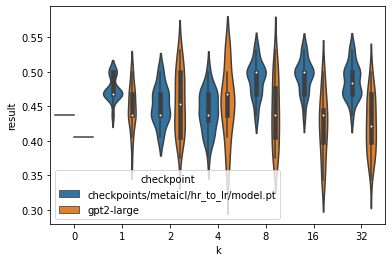

ethos-national_origin


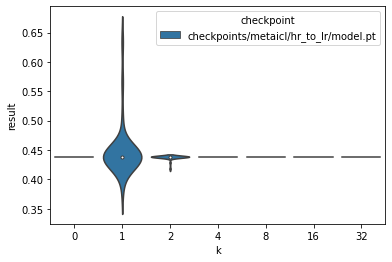

openbookqa


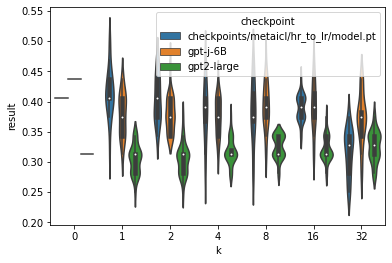

quartz-no_knowledge


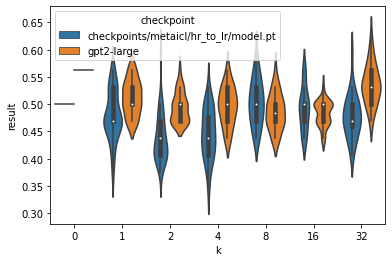

qasc


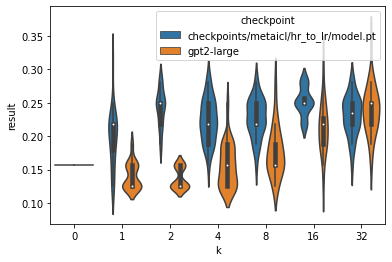

climate_fever


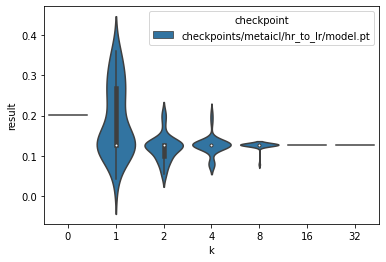

codah


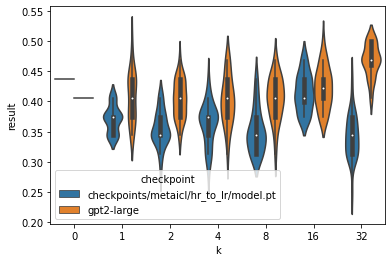

medical_questions_pairs


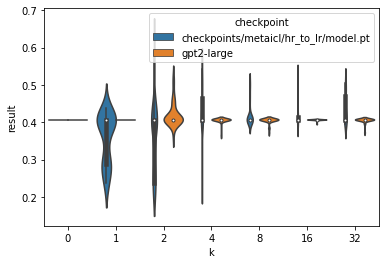

commonsense_qa


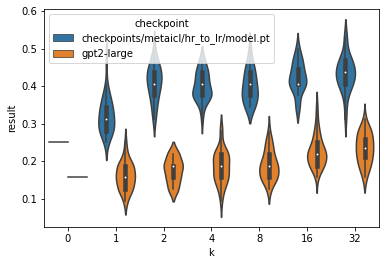

quartz-with_knowledge


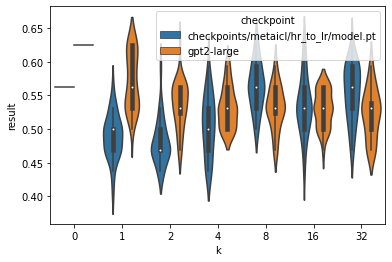

glue-wnli


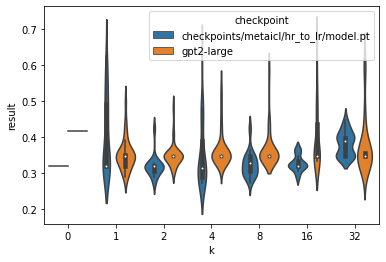

quarel


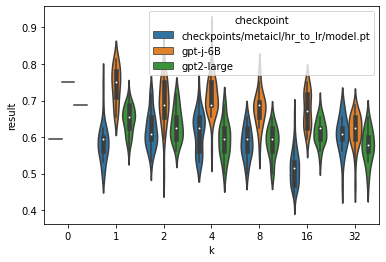

ethos-race


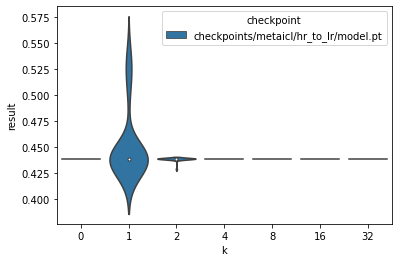

sick


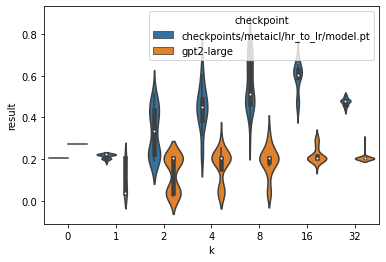

glue-mrpc


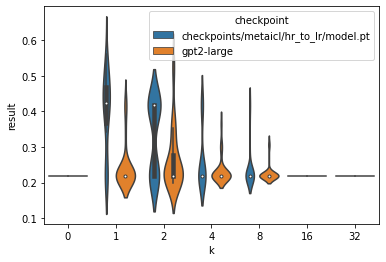

ethos-religion


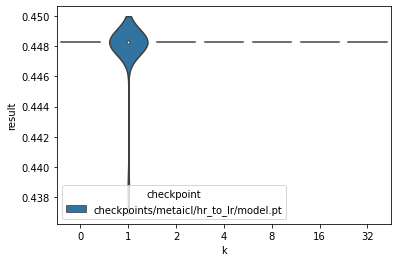

poem_sentiment


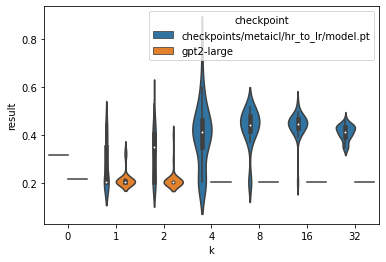

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
for task in set(df.task):
    print(task)
    sns.violinplot(data=df[df.task == task], x='k', y='result', hue='checkpoint')
    plt.show()
#     plt.savefig(os.path.join('results_dir', 'accuracy_dists_%s.pdf' % ck))

In [6]:
# task_corrs = {}
task_k_corrs = []
task_checkpoint_corrs = []
for task in set(df.task):
    checkpoints = sorted(list(set(df[df.task == task].checkpoint)))
    for ch in checkpoints:
        selected_rows = df[(df.task == task) & (df.checkpoint == ch)]
        task_k_corrs.append({
            'task': task,
            'checkpoint': ch,
            'k_corr': selected_rows.k.corr(selected_rows.result),
        })
    selected_rows = df[(df.task == task)]
    task_k_corrs.append({
        'task': task,
        'k_corr': selected_rows.k.corr(selected_rows.result),
    })
for task in set(df.task):
    checkpoints = sorted(list(set(df[df.task == task].checkpoint)))
    for i, ch1 in enumerate(checkpoints[:-1]):
        ch1_results = df[(df.task==task) & (df.checkpoint==ch1)].reset_index().result
        for ch2 in checkpoints[i + 1:]:
            ch2_results = df[(df.task==task) & (df.checkpoint==ch2)].reset_index().result
            corr = ch1_results.corr(ch2_results)
            ch1, ch2 = sorted([ch1, ch2])
            name = ' '.join([ch1, ch2])
            selected_rows = df[(df.task == task) & ((df.checkpoint == ch1) | (df.checkpoint == ch2))]
            k_corr = selected_rows.k.corr(selected_rows.result)
            task_checkpoint_corrs.append({
                'task': task,
                'between_ckpts': name,
                'ckpt_corr': corr,
                'k_corr': k_corr,
            })
task_k_corrs = pd.DataFrame(task_k_corrs)
task_checkpoint_corrs = pd.DataFrame(task_checkpoint_corrs)

In [7]:
task_k_corrs

,task,checkpoint,k_corr
0,dream,checkpoints/metaicl/hr_to_lr/model.pt,0.347833
1,dream,gpt2-large,-0.256152
2,dream,NaN,-0.007954
3,ethos-national_origin,checkpoints/metaicl/hr_to_lr/model.pt,-0.071456
4,ethos-national_origin,NaN,-0.071456
5,openbookqa,checkpoints/metaicl/hr_to_lr/model.pt,-0.566279
6,openbookqa,gpt-j-6B,-0.034214
7,openbookqa,gpt2-large,0.270974
8,openbookqa,NaN,-0.157355
9,quartz-no_knowledge,checkpoints/metaicl/hr_to_lr/model.pt,0.163205


In [8]:
task_checkpoint_corrs

,task,between_ckpts,ckpt_corr,k_corr
0,dream,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,-0.131782,-0.007954
1,openbookqa,checkpoints/metaicl/hr_to_lr/model.pt gpt-j-6B,0.108674,-0.338450
2,openbookqa,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,-0.158056,-0.214397
3,openbookqa,gpt-j-6B gpt2-large,0.048326,0.057696
4,quartz-no_knowledge,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,0.030459,0.198870
5,qasc,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,0.169429,0.432262
6,codah,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,0.037129,0.210645
7,medical_questions_pairs,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,-0.385215,0.201378
8,commonsense_qa,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,0.379567,0.210889
9,quartz-with_knowledge,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,-0.054781,0.134248


### For the each of the tasks, what is the correlation between two different models' scores across the same prompts.

[Text(0, 0, 'checkpoints/metaicl/hr_to_lr/model.pt gpt2-large')]

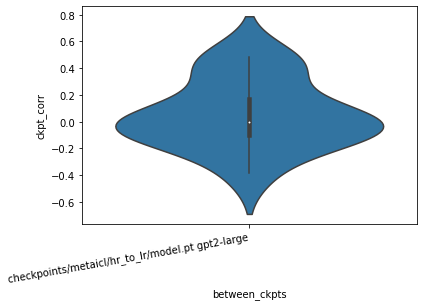

In [9]:
# chart = sns.violinplot(data=task_checkpoint_corrs, x='between_ckpts', y='ckpt_corr')
chart = sns.violinplot(data=task_checkpoint_corrs[task_checkpoint_corrs.between_ckpts=='checkpoints/metaicl/hr_to_lr/model.pt gpt2-large'], x='between_ckpts', y='ckpt_corr')
chart.set_xticklabels(chart.get_xticklabels(), rotation=10, horizontalalignment='right')


[Text(0, 0, 'medical_questions_pairs'),
 Text(1, 0, 'openbookqa'),
 Text(2, 0, 'dream'),
 Text(3, 0, 'glue-wnli'),
 Text(4, 0, 'quartz-with_knowledge'),
 Text(5, 0, 'quarel'),
 Text(6, 0, 'poem_sentiment'),
 Text(7, 0, 'quartz-no_knowledge'),
 Text(8, 0, 'codah'),
 Text(9, 0, 'qasc'),
 Text(10, 0, 'commonsense_qa'),
 Text(11, 0, 'glue-mrpc'),
 Text(12, 0, 'sick')]

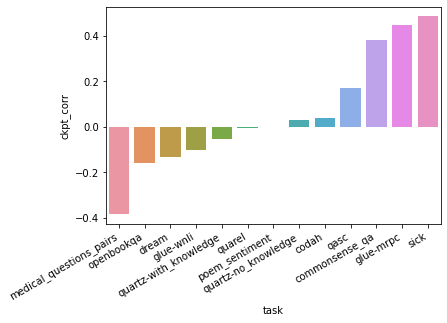

In [11]:
chart = sns.barplot(
    data=task_checkpoint_corrs[task_checkpoint_corrs.between_ckpts=='checkpoints/metaicl/hr_to_lr/model.pt gpt2-large'].sort_values('ckpt_corr'),
    x='task', y='ckpt_corr')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

### Is the correlation of the scores for different models correlated with how much the task benefits from examples?

In [12]:
# rows = task_checkpoint_corrs
rows = task_checkpoint_corrs[task_checkpoint_corrs.between_ckpts=='checkpoints/metaicl/hr_to_lr/model.pt gpt2-large']
rows.ckpt_corr.corr(rows.k_corr)


0.02781218429301402

### For each task, what is the correlation between number of examples in the prompt and the score? In other words, how few-shot-learnable is a task?

[Text(0, 0, 'glue-mrpc'),
 Text(1, 0, 'quarel'),
 Text(2, 0, 'climate_fever'),
 Text(3, 0, 'openbookqa'),
 Text(4, 0, 'ethos-race'),
 Text(5, 0, 'ethos-national_origin'),
 Text(6, 0, 'dream'),
 Text(7, 0, 'ethos-religion'),
 Text(8, 0, 'glue-wnli'),
 Text(9, 0, 'quartz-with_knowledge'),
 Text(10, 0, 'poem_sentiment'),
 Text(11, 0, 'quartz-no_knowledge'),
 Text(12, 0, 'medical_questions_pairs'),
 Text(13, 0, 'codah'),
 Text(14, 0, 'commonsense_qa'),
 Text(15, 0, 'sick'),
 Text(16, 0, 'qasc')]

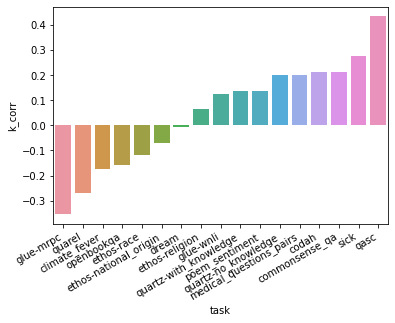

In [15]:
chart = sns.barplot(data=task_k_corrs[task_k_corrs.checkpoint.isna()].sort_values('k_corr'), x='task', y='k_corr')
# chart = sns.barplot(data=task_k_corrs[task_k_corrs.checkpoint == 'checkpoints/metaicl/hr_to_lr/model.pt'].sort_values('k_corr'), x='task', y='k_corr')
# chart = sns.barplot(data=task_k_corrs[task_k_corrs.checkpoint == 'gpt2-large'].sort_values('k_corr'), x='task', y='k_corr')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right')

### What does the distribution of few-shot-learnability (correlation of # of examples with score) over tasks for each model look like?

[Text(0, 0, 'checkpoints/metaicl/hr_to_lr/model.pt'),
 Text(1, 0, 'gpt2-large'),
 Text(2, 0, 'gpt-j-6B')]

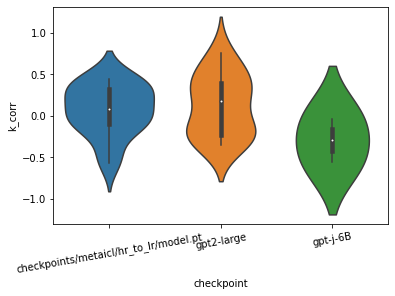

In [16]:
chart = sns.violinplot(data=task_k_corrs[~task_k_corrs.checkpoint.isna()], x='checkpoint', y='k_corr')
chart.set_xticklabels(chart.get_xticklabels(), rotation=10, horizontalalignment='center')

### If a task is few-shot-learnable for one model, does that mean it will be for a different model?

In [17]:
ckpts = sorted(list(set(task_k_corrs[~task_k_corrs.checkpoint.isna()].checkpoint)))
model_k_corr_corrs = []
for i, ch1 in enumerate(ckpts[:-1]):
    for ch2 in ckpts[i + 1:]:
        ch1, ch2 = sorted([ch1, ch2])
        name = ' '.join([ch1, ch2])
        k_corr_1 = task_k_corrs[task_k_corrs.checkpoint == ch1].sort_values('task').reset_index().k_corr
        k_corr_2 = task_k_corrs[task_k_corrs.checkpoint == ch2].sort_values('task').reset_index().k_corr
        model_k_corr_corrs.append({
            'between_ckpts': name,
            'k_corr_corr': k_corr_1.corr(k_corr_2),
        })
model_k_corr_corrs = pd.DataFrame(model_k_corr_corrs)
model_k_corr_corrs

,between_ckpts,k_corr_corr
0,checkpoints/metaicl/hr_to_lr/model.pt gpt-j-6B,-1.00000
1,checkpoints/metaicl/hr_to_lr/model.pt gpt2-large,-0.34673
2,gpt-j-6B gpt2-large,1.00000
